<a href="https://colab.research.google.com/github/sunmario/my_code/blob/master/pymorphy_features_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import string
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch

# План
1. Описываем задачу и датасет. Как выделили тест и валид, частотности знаков  препинания,
2. Извлечение признаков - морфологические признаки(pymorphy2)
3. Классические методы МО
4. Глубокая нейронная сеть
5. Сравнение результатов


| Архитектура                                       	| F мера по пробелам 	| F мера по запятым 	| F мера по точкам 	|
|---------------------------------------------------	|--------------------	|-------------------	|------------------	|
| Дерево решений(глубина 12,энтропия)               	| 0.66               	| 0.24              	| 0.51             	|
| Мажоритарное голосование(линSVC,логрегресс,байес) 	| 0.67               	| 0.25              	| 0.49             	|
| DNN(3 линейных слоя,relu,adam)                    	| 0.67               	| 0.26              	| 0.51             	|


# 1.1 Подготовка данных


## Данные: Шаг 1 - загрузка датасета 

In [ ]:
# Download ru.conversations.txt
!wget -P data/Conversations https://github.com/Koziev/NLP_Datasets/raw/master/Conversations/Data/ru.conversations.txt


--2021-06-17 19:57:23--  https://github.com/Koziev/NLP_Datasets/raw/master/Conversations/Data/ru.conversations.txt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Koziev/NLP_Datasets/master/Conversations/Data/ru.conversations.txt [following]
--2021-06-17 19:57:23--  https://raw.githubusercontent.com/Koziev/NLP_Datasets/master/Conversations/Data/ru.conversations.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9718314 (9.3M) [text/plain]
Saving to: ‘data/Conversations/ru.conversations.txt’

ru.conversations.tx 100%[===================>]   9.27M  21.4MB/s    in 0.4s    

2021-06-17 19:57:24 (21

In [ ]:
# Download dialogues.txt
!wget -P data/Conversations https://github.com/Koziev/NLP_Datasets/raw/master/Conversations/Data/dialogues.zip
!unzip -d data/Conversations data/Conversations/dialogues.zip

--2021-06-17 19:57:24--  https://github.com/Koziev/NLP_Datasets/raw/master/Conversations/Data/dialogues.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Koziev/NLP_Datasets/master/Conversations/Data/dialogues.zip [following]
--2021-06-17 19:57:24--  https://raw.githubusercontent.com/Koziev/NLP_Datasets/master/Conversations/Data/dialogues.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30699585 (29M) [application/zip]
Saving to: ‘data/Conversations/dialogues.zip’

dialogues.zip       100%[===================>]  29.28M  37.2MB/s    in 0.8s    

2021-06-17 19:57:26 (37.2 MB/s) - ‘data/Conver

## Данные: Шаг 2 - Разбиваем на train, val, test
* TRAIN_lines - коллекция всех строк для обучения
* VAL_lines - небольшая подвыборка из строк ru.conversations.txt
* TEST_lines - большой подвыборка из dialogues.txt

In [ ]:
def load_file(fname):
    with open(fname, "r", encoding="utf-8") as f:
        lines = [line for line in map(lambda s: s.strip("-").strip(), f.readlines()) if line]
    return lines

ru_conv_lines = load_file("data/Conversations/ru.conversations.txt")
dialogues_lines = load_file("data/Conversations/dialogues.txt")
print(f"ru.conversations.txt: num lines {len(ru_conv_lines)}")
#print(f"dialogues.txt: num lines {len(dialogues_lines)}")

ru_conv_lines_train, ru_conv_lines_val = train_test_split(ru_conv_lines, test_size=0.3, shuffle=False)
dialogues_lines_train, dialogues_lines_val = train_test_split(dialogues_lines, test_size=0.1, shuffle=False)

TRAIN_lines_ru_conv = ru_conv_lines_train
TRAIN_lines = np.concatenate((ru_conv_lines_train, dialogues_lines_train))
VAL_lines = ru_conv_lines_val
TEST_lines = dialogues_lines_val
#print(f"TRAIN_lines: {len(TRAIN_lines)}. Average line len ( in words): {np.average([len(s.split()) for s in TRAIN_lines])}")
print(f"VAL_lines: {len(VAL_lines)}. Average line len ( in words): {np.average([len(s.split()) for s in VAL_lines])}")
#print(f"TEST_lines: {len(TEST_lines)}. Average line len ( in words): {np.average([len(s.split()) for s in TEST_lines])}")

ru.conversations.txt: num lines 246295
VAL_lines: 73889. Average line len ( in words): 3.441067005914277


## Данные: Шаг 3 - отделяем знаки препинания от слов

Данные и метки классов хранятся в этих коллекциях 
* TRAIN_WORDS, TRAIN_LABELS - массив массивов с словами и массив с массивом пунктуации для TRAIN
* VAL_WORDS, VAL_LABELS - same for VAL
* TEST_WORDS, TEST_LABELS - same for TEST

In [ ]:
PUNCTUATIONS = {"": 0, ".": 1, ",": 2}
punct_mapping = {"!": ".", "?": ".", "...": ".", ":": "", "*":'',
                 "'": "", '"':"", "(": "", ")": "", "{": "", "}": "", 
                 "[": '', "]": "",
                 ".": ".", ",":",",}

def tokenize(text):   
  """Tokenize text. Split words and punctuations"""
  legal_in_word_sym = "-"
  for p, map_p in punct_mapping.items():
    text = text.replace(p, f" {map_p} ")
  return text.lower().split()

def separate_words_and_puncts(tokenized_text):
  """Generate raw text and punctuation labels arrays from tokenized text."""
  words = []
  labels = []
  appended_label = True
  for word in tokenized_text:
    if word in PUNCTUATIONS:
      if not appended_label:
        labels.append(word)
        appended_label = True
    else:
      if word in string.punctuation:
        continue
      words.append(word)
      if not appended_label:
        labels.append("")
      appended_label = False
  if not appended_label:
    labels.append('')
  assert len(words) == len(labels), f"{words} \n {labels}"
  return words, labels

def extract_punctuations(lines):
  """Generate X,Y from input text lines """
  x, y = [] , []
  for line in tqdm(lines):
    line_splited = tokenize(line.strip())
    words, labels = separate_words_and_puncts(line_splited)
    if words:
      x.append(words)
      y.append(labels)
  return x, y 

TRAIN_WORDS_ru_conv, TRAIN_LABELS_ru_conv = extract_punctuations(TRAIN_lines_ru_conv)
TRAIN_WORDS, TRAIN_LABELS = extract_punctuations(TRAIN_lines)
VAL_WORDS, VAL_LABELS = extract_punctuations(VAL_lines)
TEST_WORDS, TEST_LABELS = extract_punctuations(TEST_lines)

100%|██████████| 291220/291220 [00:05<00:00, 53000.63it/s]


In [ ]:
# пример
print("Пример того, как выглядит первый элемент в VAL")
print("Формат  - '<WORD>': '<LABEL>'")
print(f"Оригинал: '{VAL_lines[0]}'")
print("---")
for word, label in zip(VAL_WORDS[0], VAL_LABELS[0]):
  print(f"'{word}': '{label}'")

Пример того, как выглядит первый элемент в VAL
Формат  - '<WORD>': '<LABEL>'
Оригинал: 'Гвоздья бы мяе... Есть гвоздье?'
---
'гвоздья': ''
'бы': ''
'мяе': '.'
'есть': ''
'гвоздье': '.'


In [ ]:
# Статистика по классам

def get_statistic(label_lines):
  labels = np.concatenate(label_lines)
  empty = (labels == '').sum()
  comma = (labels == ',').sum()
  dot = (labels == '.').sum()
  print(f"empty:{empty} comma:{comma} dot:{dot}")

print("TRAIN")
get_statistic(TRAIN_LABELS)
print("VAL")
get_statistic(VAL_LABELS)
print("TEST")
get_statistic(TEST_LABELS)

TRAIN
empty:7266648 comma:1514869 dot:2981645
VAL
empty:144404 comma:20992 dot:87126
TEST
empty:766118 comma:163749 dot:307740


# 2 Выделение признаков с помощью pymorphy2
Для обучающей выборки была создана сбалансированная выборка(12000 объектов, 4000 каждого класса)
Для извлечения признаков были собраны все граммемы и преобразованы в бинарный вектор длины 52


In [ ]:
from itertools import chain
train_labels = np.concatenate(TRAIN_LABELS_ru_conv)
train_words = np.concatenate(TRAIN_WORDS_ru_conv)

balanced_ids_train = np.concatenate((np.where(train_labels == '')[0][:4000],
                              np.where(train_labels == ',')[0][:4000],
                              np.where(train_labels == '.')[0][:4000]))


balanced_words_train,balanced_labels_train = train_words[balanced_ids_train],train_labels[balanced_ids_train]

test_labels = np.concatenate(TEST_LABELS)[:3600]
test_words = np.concatenate(TEST_WORDS)[:3600]

!pip install pymorphy2
import pymorphy2


def binary_morph_feat(wordlines):
  morph = pymorphy2.MorphAnalyzer()
  TRAIN_WORDS_FEAT = []
  for i in tqdm(range(len(wordlines)),disable=True):
      p = morph.parse(wordlines[i])[0].tag
      TRAIN_WORDS_FEAT.append(p)
  all_gramems = ["POS", "animacy", "gender", "number", "case", "aspect",
    "transitivity", "person", "tense", "mood", "voice","involvement"]
  gramem_cat = [
              ["NOUN","ADJF","ADJS",
               "COMP","VERB","INFN",
               "PRTF","PRTS","GRND",
               "NUMR","ADVB","NPRO",
               "PRED","PREP","CONJ",
               "PRCL","INTJ"],
                ["anim","inan"],
                ["masc","femn","neut"],
                ["sing","plur"],
                ["nomn","gent","datv",
                "accs","ablt","loct",
                "voct", "gen1","gen2",
                "acc2","loc1","loc2"],
                ["perf","impf"],
                ["tran","intr"],
                ["1per","2per","3per"],
                ["pres","past","futr"],
                ["indc","impr"],
                ["actv","pssv"],
                ["incl","excl"]
                ]
  gram = list(chain(*gramem_cat))
  binary_vector = []
  for i in tqdm(range(len(TRAIN_WORDS_FEAT)),disable=True):
    bi = []
    for j in tqdm(range(len(all_gramems)),disable=True):
      at = (getattr(TRAIN_WORDS_FEAT[i],all_gramems[j]))
      if at is not None:
        try:
          if at in gramem_cat[j]:
            bi_ = [0 for i in range(len(gramem_cat[j]))]
            bi_[gramem_cat[j].index(at)] = 1
        except ValueError:
          bi_ = [0 for i in range(len(gramem_cat[j]))]
      else:
        bi_ = [0 for i in range(len(gramem_cat[j]))]
      bi.append(bi_)
    bi = list(chain(*bi))
    binary_vector.append(bi)
  binary_vector = np.array(binary_vector)
  return binary_vector

binary_train = binary_morph_feat(balanced_words_train)
binary_test = binary_morph_feat(test_words)

     |████████████████████████████████| 61kB 2.3MB/s 
     |████████████████████████████████| 8.2MB 5.7MB/s 


# 3 Классические методы машинного обучения
Для применения методов был использован GridSearch, с помощью которого были выявлены оптимальные параметры для каждого из методов


# Дерево решений


In [ ]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier as dectree
from sklearn.model_selection import GridSearchCV
import pandas as pd
dt_ = dectree()
params = {"max_depth":[i for i in range(2,52)],"criterion":["gini", "entropy"]}
clf = GridSearchCV(dt_,params)
clf.fit(binary_train, balanced_labels_train)

results_df = pd.DataFrame(clf.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (results_df .set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))).rename_axis('max_depth'))
results_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]


,params,rank_test_score,mean_test_score,std_test_score
max_depth,,,,
entropy_12,"{'criterion': 'entropy', 'max_depth': 12}",1,0.510500,0.022894
entropy_17,"{'criterion': 'entropy', 'max_depth': 17}",2,0.510000,0.026401
entropy_15,"{'criterion': 'entropy', 'max_depth': 15}",3,0.509833,0.025872
entropy_16,"{'criterion': 'entropy', 'max_depth': 16}",4,0.509417,0.026035
entropy_13,"{'criterion': 'entropy', 'max_depth': 13}",5,0.509083,0.024333
...,...,...,...,...
entropy_4,"{'criterion': 'entropy', 'max_depth': 4}",96,0.467250,0.008837
gini_3,"{'criterion': 'gini', 'max_depth': 3}",97,0.453833,0.008992
entropy_3,"{'criterion': 'entropy', 'max_depth': 3}",98,0.448250,0.007276


In [ ]:
dt_opt = dectree(max_depth=12,criterion = "entropy")
dt_opt.fit(binary_train, balanced_labels_train)
expected = test_labels
predicted = dt_opt.predict(binary_test)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))


              precision    recall  f1-score   support

                   0.79      0.57      0.66      2209
           ,       0.21      0.29      0.24       523
           .       0.43      0.62      0.51       868

    accuracy                           0.55      3600
   macro avg       0.48      0.50      0.47      3600
weighted avg       0.62      0.55      0.57      3600

[[1270  453  486]
 [ 146  154  223]
 [ 197  129  542]]


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
gaus_ = GaussianNB()
params = {'var_smoothing': np.logspace(0,-9, num=100)}
clf_nb = GridSearchCV(gaus_,params)
clf_nb.fit(binary_train, balanced_labels_train)

results_df = pd.DataFrame(clf_nb.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (results_df .set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))).rename_axis('var_smoothing'))
results_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]

,params,rank_test_score,mean_test_score,std_test_score
var_smoothing,,,,
0.08111308307896872,{'var_smoothing': 0.08111308307896872},1,0.511750,0.015522
0.0657933224657568,{'var_smoothing': 0.0657933224657568},2,0.511583,0.015292
0.1,{'var_smoothing': 0.1},3,0.511250,0.016109
0.0533669923120631,{'var_smoothing': 0.0533669923120631},4,0.511250,0.015303
0.04328761281083057,{'var_smoothing': 0.04328761281083057},5,0.510167,0.015107
...,...,...,...,...
2.310129700083158e-09,{'var_smoothing': 2.310129700083158e-09},96,0.437833,0.023743
1.873817422860387e-09,{'var_smoothing': 1.873817422860387e-09},97,0.437750,0.023743
1.519911082952933e-09,{'var_smoothing': 1.519911082952933e-09},98,0.437333,0.023762


# Мажоритарное голосование(Логистическая регрессия, Наивный Байес, Линейный SVC)

In [ ]:
svc_ = LinearSVC()
params = {"C": [1, 10],"loss":["hinge", "square_hinge"]}
clf_svc = GridSearchCV(svc_,params)
clf_svc.fit(binary_train, balanced_labels_train)

results_df = pd.DataFrame(clf_svc.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (results_df .set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))).rename_axis('params'))
results_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: loss='square_hinge' is not supported, Parameters: penalty='l2', loss='square_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: loss='square_hinge' is not supported, Parameters: penalty='l2', loss='square_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: los

,params,rank_test_score,mean_test_score,std_test_score
params,,,,
1_hinge,"{'C': 1, 'loss': 'hinge'}",1,0.455333,0.018807
10_hinge,"{'C': 10, 'loss': 'hinge'}",2,0.441083,0.037156
1_square_hinge,"{'C': 1, 'loss': 'square_hinge'}",3,NaN,NaN
10_square_hinge,"{'C': 10, 'loss': 'square_hinge'}",4,NaN,NaN


In [ ]:
log_ = LogisticRegression(n_jobs=1)
params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
clf_log = GridSearchCV(log_,params,n_jobs=None)
clf_log.fit(binary_train, balanced_labels_train)

results_df = pd.DataFrame(clf_log.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (results_df .set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))).rename_axis('params'))
results_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_se

,params,rank_test_score,mean_test_score,std_test_score
params,,,,
100.0_l2,"{'C': 100.0, 'penalty': 'l2'}",1,0.511500,0.017687
1000.0_l2,"{'C': 1000.0, 'penalty': 'l2'}",1,0.511500,0.017730
10.0_l2,"{'C': 10.0, 'penalty': 'l2'}",3,0.511167,0.017521
1.0_l2,"{'C': 1.0, 'penalty': 'l2'}",4,0.511000,0.017942
0.01_l2,"{'C': 0.01, 'penalty': 'l2'}",5,0.510917,0.017239
0.1_l2,"{'C': 0.1, 'penalty': 'l2'}",5,0.510917,0.017255
0.001_l2,"{'C': 0.001, 'penalty': 'l2'}",7,0.493167,0.012006
0.001_l1,"{'C': 0.001, 'penalty': 'l1'}",8,NaN,NaN
0.01_l1,"{'C': 0.01, 'penalty': 'l1'}",9,NaN,NaN


In [ ]:


clf1 = LogisticRegression(C = 100,penalty="l2")
clf2 = LinearSVC(C = 10,loss="hinge")
clf3 = GaussianNB(var_smoothing = 0.0811)
eclf = VotingClassifier(estimators=[
                                     ('lr', clf1), ('svc', clf2), ('gnb', clf3)], voting='hard')
eclf.fit(binary_train,balanced_labels_train)

expected = test_labels
predicted = eclf.predict(binary_test)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

                   0.78      0.60      0.68      2209
           ,       0.21      0.30      0.25       523
           .       0.43      0.56      0.49       868

    accuracy                           0.55      3600
   macro avg       0.47      0.49      0.47      3600
weighted avg       0.61      0.55      0.57      3600

[[1329  435  445]
 [ 153  157  213]
 [ 223  155  490]]


In [ ]:
def xx(labels):
  PUNCTUATIONS = {"": 0, ".": 1, ",": 2}
  lb = []
  for i in labels:
    lb.append(PUNCTUATIONS[i])
  return lb
test_labels = xx(test_labels)
train_labels = xx(balanced_labels_train)

# Нейронные сети DNN
В архитектуре используется:
3 линейных слоя
функция активации - relu
оптимайзеры - Адам, АдамВ, Ададельта
среди них и разных скоростей обучения лучший результат показал Адам со скоростью 0.001

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Finished Training


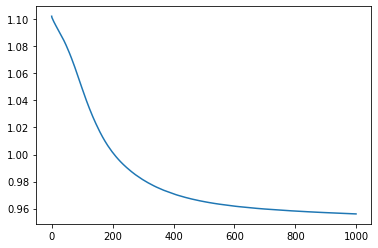

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt



batch_size = 128
new_size = (12000//batch_size)*batch_size
train_feat = torch.tensor(binary_train[:new_size],dtype = torch.float32).reshape((-1,batch_size,52))
train_labels = torch.tensor(train_labels[:new_size],dtype=torch.float32).reshape((-1,batch_size))


class Net(nn.Module):
    def __init__(self):
      super().__init__()
      self.fc1 = nn.Linear(52, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 3)

    def forward(self,x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

net1 = Net()

criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(net1.parameters(), lr=0.00001)
loss_graph = []

for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for feats, labels in zip(train_feat,train_labels):
        # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
        optimizer1.zero_grad()

        # forward + backward + optimize
        outputs = net1(feats)
        labels = labels.type(torch.LongTensor)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer1.step()

        # print statistics
        running_loss += loss.item()
    loss_graph.append(running_loss/len(train_feat))
    running_loss = 0.0

print('Finished Training')
plt.plot(loss_graph)
plt.show()

Finished Training


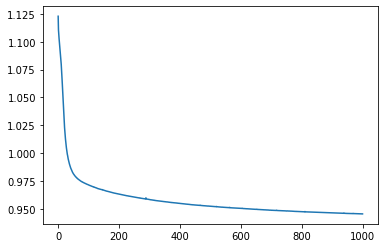

In [ ]:
net2 = Net()


optimizer2 = optim.Adam(net2.parameters(), lr=0.0001)
loss_graph = []

for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for feats, labels in zip(train_feat,train_labels):
        # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        outputs = net2(feats)
        labels = labels.type(torch.LongTensor)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
    loss_graph.append(running_loss/len(train_feat))
    running_loss = 0.0

print('Finished Training')
plt.plot(loss_graph)
plt.show()

Finished Training


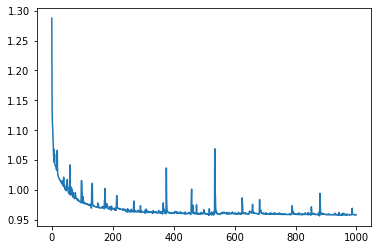

In [ ]:
net3 = Net()

criterion = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(net3.parameters(), lr=0.001)
loss_graph = []

for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for feats, labels in zip(train_feat,train_labels):
        # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
        optimizer3.zero_grad()

        # forward + backward + optimize
        outputs = net3(feats)
        labels = labels.type(torch.LongTensor)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer3.step()

        # print statistics
        running_loss += loss.item()
    loss_graph.append(running_loss/len(train_feat))
    running_loss = 0.0

print('Finished Training')
plt.plot(loss_graph)
plt.show()

Finished Training


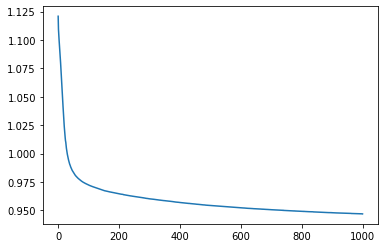

In [ ]:
net4 = Net()


optimizer4 = optim.AdamW(net4.parameters(), lr=0.0001)
loss_graph = []

for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for feats, labels in zip(train_feat,train_labels):
        # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
        optimizer4.zero_grad()

        # forward + backward + optimize
        outputs = net4(feats)
        labels = labels.type(torch.LongTensor)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer4.step()

        # print statistics
        running_loss += loss.item()
    loss_graph.append(running_loss/len(train_feat))
    running_loss = 0.0

print('Finished Training')
plt.plot(loss_graph)
plt.show()

Finished Training


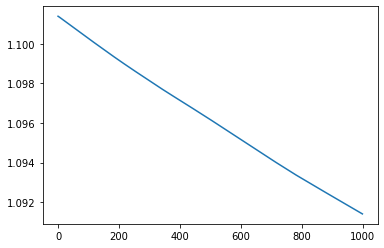

In [ ]:
net5 = Net()

criterion = nn.CrossEntropyLoss()
optimizer5 = optim.Adadelta(net5.parameters(), lr=0.0001)
loss_graph = []

for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for feats, labels in zip(train_feat,train_labels):
        # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
        optimizer5.zero_grad()

        # forward + backward + optimize
        outputs = net5(feats)
        labels = labels.type(torch.LongTensor)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer5.step()

        # print statistics
        running_loss += loss.item()
    loss_graph.append(running_loss/len(train_feat))
    running_loss = 0.0

print('Finished Training')
plt.plot(loss_graph)
plt.show()

In [ ]:
new_size = (3600//batch_size)*batch_size

test_feat = torch.tensor(binary_test[:new_size],dtype = torch.float32).reshape((-1,batch_size,52))
test_labels = torch.tensor(test_labels[:new_size],dtype=torch.float32).reshape((-1,batch_size))

nets = [net1,net2,net3,net4,net5]
opts = [optimizer1,optimizer2,optimizer3,optimizer4,optimizer5]

 # loop over the dataset multiple times
outputs_comp = []
running_loss = 0.0
for i,j in zip(nets,opts):
  outputq = []
  for feats, labels in zip(test_feat,test_labels):
      # get the inputs; data is a list of [inputs, labels]

      # zero the parameter gradients
      j.zero_grad()

      # forward + backward + optimize
      outputs = i(feats)
      maxi = torch.argmax(outputs,dim = -1)
      outputq.append(maxi.tolist())
      labels = labels.type(torch.LongTensor)

      loss = criterion(outputs, labels)
      loss.backward()
      j.step()
  outputs_comp.append(outputq)
print('Finished Training')
expected = list(chain(*test_labels.tolist()))
for i in outputs_comp:
  predicted = list(chain(*i))
  print(metrics.classification_report(expected, predicted))
  print(metrics.confusion_matrix(expected, predicted))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


Finished Training
              precision    recall  f1-score   support

         0.0       0.79      0.58      0.67      2201
         1.0       0.43      0.59      0.49       863
         2.0       0.20      0.31      0.24       520

    accuracy                           0.54      3584
   macro avg       0.47      0.49      0.47      3584
weighted avg       0.62      0.54      0.56      3584

[[1272  458  471]
 [ 202  505  156]
 [ 143  218  159]]
              precision    recall  f1-score   support

         0.0       0.79      0.56      0.65      2201
         1.0       0.43      0.61      0.51       863
         2.0       0.21      0.32      0.25       520

    accuracy                           0.54      3584
   macro avg       0.48      0.50      0.47      3584
weighted avg       0.62      0.54      0.56      3584

[[1227  481  493]
 [ 191  526  146]
 [ 141  212  167]]
              precision    recall  f1-score   support

         0.0       0.79      0.58      0.67      2201
 

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([1, 1, 2, 2])
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)